In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# SPDX-License-Identifier: CC-BY-4.0
#
# Code for "Bayesian continual learning and forgetting in neural networks"
# Djohan Bonnet, Kellian Cottart, Tifenn Hirtzlin, Tarcisius Januel, Thomas Dalgaty, Elisa Vianello, Damien Querlioz
# arXiv: 2504.13569
# Portions of the code are adapted from the Pytorch project (BSD-3-Clause)
#
# Author: Kellian Cottart <kellian.cottart@gmail.com>
# Date: 2025-07-03

In [2]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os
import seaborn as sns
import re
FOLDER = "output-figures"
os.makedirs(FOLDER, exist_ok=True)

# put jax in cpu mode
jax.config.update("jax_platform_name", "cpu")

results_folder = "RESULTS-MNIST-OOD"

# Function to find paths with correct optimizer
def find_paths(results_folder, optimizer):
    paths = []
    for root, dirs, files in os.walk(results_folder):
        for dir_name in dirs:
            if re.search(f"opt={optimizer}", dir_name)  and not (re.search("ewc", dir_name) and optimizer == "sgd"):
                paths.append(os.path.join(root, dir_name))
    return paths

optimizers = ["mesu", "foovbdiagonal", "sgd-stream", "sgd"]
# Find paths for each optimizer
paths = []
for optimizer in optimizers:
        paths.extend(find_paths(results_folder, optimizer))

In [ ]:
n_iterations = 5
n_tasks = 1
n_epochs = 1000
data = []
for path in paths:
    full_accuracies, full_epistemic_roc_auc, full_aleatoric_roc_auc, full_epistemic, full_ood_epistemic, full_aleatoric, full_ood_aleatoric, full_params_0, full_params_1 = [], [], [], [], [], [], [], [], []
    for it in range(n_iterations):
        current_it_path = os.path.join(path, f"config{it}")
        accuracy_path = os.path.join(current_it_path, "accuracy")
        uncertainty_path = os.path.join(current_it_path, "uncertainty")
        weights_path = os.path.join(current_it_path, "weights")
        
        accuracies, epistemic_roc_auc, aleatoric_roc_auc, epistemic, ood_epistemic, aleatoric, ood_aleatoric = [], [], [], [], [], [], []
        
        for task in range(n_tasks):
            for epoch in range(n_epochs):
                suffix = f"task={task}-epoch={epoch}.npy"
                accuracies.append(jnp.load(os.path.join(accuracy_path, suffix)))
                epistemic_roc_auc.append(jnp.load(os.path.join(uncertainty_path, f"roc-auc-epistemic-{suffix}")))
                aleatoric_roc_auc.append(jnp.load(os.path.join(uncertainty_path, f"roc-auc-aleatoric-{suffix}")))
                epistemic.append(jnp.load(os.path.join(uncertainty_path, f"epistemic-{suffix}")))
                ood_epistemic.append(jnp.load(os.path.join(uncertainty_path, f"ood-epistemic-{suffix}")))
                aleatoric.append(jnp.load(os.path.join(uncertainty_path, f"aleatoric-{suffix}")))
                ood_aleatoric.append(jnp.load(os.path.join(uncertainty_path, f"ood-aleatoric-{suffix}")))
        
        if "foovbdiagonal" in path or "mesu" in path:
            param_sigma_0, param_sigma_1 = [], []
            for task in range(n_tasks):
                for epoch in range(n_epochs):
                    suffix = f"task={task}-epoch={epoch}.npy"
                    param_sigma_0.append(jnp.load(os.path.join(weights_path, f"layer=1-{suffix}")))
                    param_sigma_1.append(jnp.load(os.path.join(weights_path, f"layer=3-{suffix}")))
        full_accuracies.append(jnp.array(accuracies))
        full_epistemic_roc_auc.append(jnp.array(epistemic_roc_auc))
        full_aleatoric_roc_auc.append(jnp.array(aleatoric_roc_auc))
        full_epistemic.append(jnp.array(epistemic))
        full_ood_epistemic.append(jnp.array(ood_epistemic))
        full_aleatoric.append(jnp.array(aleatoric))
        full_ood_aleatoric.append(jnp.array(ood_aleatoric))
        if "foovbdiagonal" in path or "mesu" in path:
            full_params_0.append(jnp.array(param_sigma_0))
            full_params_1.append(jnp.array(param_sigma_1))
    data.append((
        jnp.array(full_accuracies), 
        jnp.array(full_epistemic_roc_auc), 
        jnp.array(full_aleatoric_roc_auc), 
        jnp.array(full_epistemic), 
        jnp.array(full_ood_epistemic), 
        jnp.array(full_aleatoric),
        jnp.array(full_ood_aleatoric),
        jnp.array(full_params_0),
        jnp.array(full_params_1)
    ))


In [ ]:
AXESSIZE = 28
FONTSIZE = 26
TICKSIZE = 24   
LEGENDSIZE = 26
plt.rcParams['svg.fonttype'] = 'none'
FIGSIZE = (10, 8)
names = ["MESU N=180,000", "MESU N=$10^{15}$", "FOO-VB Diagonal", "EWC Stream", "SGD Baseline"]
colors = [
    "#a559aa", #MESU
    "#840028", #MESU N=10^15
    "#59a89c", #FOO-VB Diagonal
    "#082a54", #EWC Stream
    '#909090'  #Baseline
]

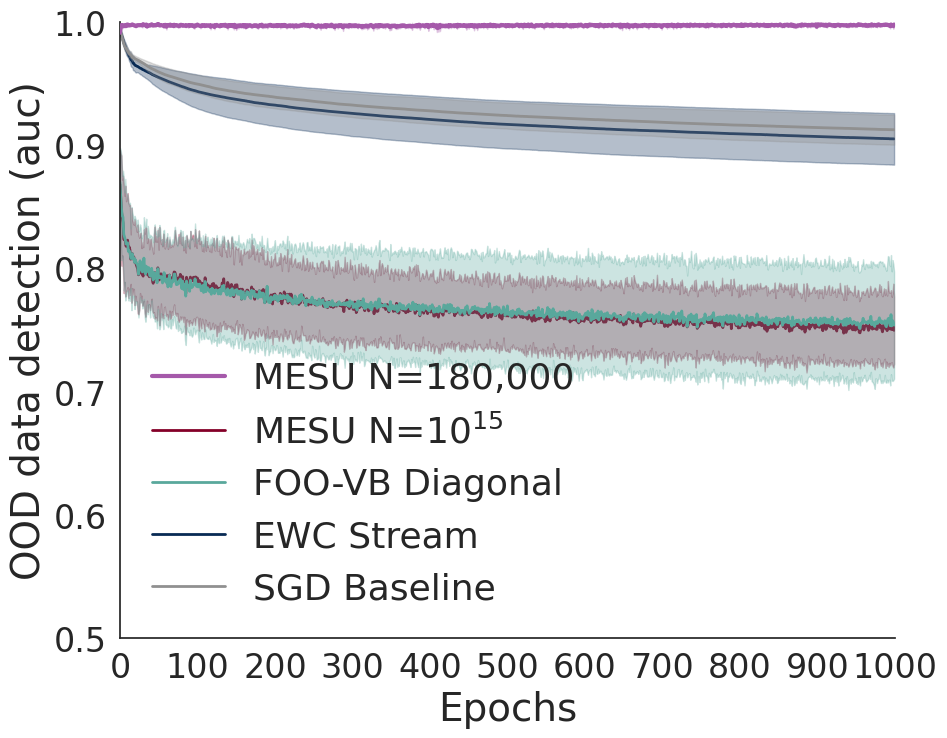

In [ ]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=FIGSIZE)
for i, alg, name in zip(range(len(data)), data, names):
    full_roc = alg[1]
    # If epistemic roc is all zeros, use aleatoric roc
    full_roc_mean = jnp.mean(full_roc, axis=0)
    full_roc_std = jnp.std(full_roc, axis=0)
    if jnp.all(full_roc_mean == 0):
        full_roc_mean = alg[2].mean(axis=0)
        full_roc_std = alg[2].std(axis=0)
    sns.lineplot(x=jnp.arange(n_epochs), 
                 y=full_roc_mean, 
                 ax=ax, 
                 label=name, 
                 color=colors[i], 
                 linewidth=3 if name == "MESU N=180,000" else 2,
                 zorder = 10 if name == "MESU N=180,000" else 1,
                    )
    ax.fill_between(jnp.arange(n_epochs), full_roc_mean - full_roc_std, full_roc_mean + full_roc_std, color=colors[i], alpha=0.3, zorder = 10 if name == "MESU" else 1,)

ax.set_xlabel("Epochs", fontsize=AXESSIZE)
ax.set_ylabel("OOD data detection (auc)", fontsize=AXESSIZE)
ax.set_xticks(jnp.arange(0, n_epochs + 1, 100))
ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
ax.legend(loc="lower left", fontsize=LEGENDSIZE, frameon=False, bbox_to_anchor=(0.0, 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, n_epochs)
ax.set_ylim(0.5, 1)
plt.show()
# savefig as pdf
fig.savefig(os.path.join(FOLDER, "mnist-roc-auc.svg"), bbox_inches="tight")
fig.savefig(os.path.join(FOLDER, "mnist-roc-auc.pdf"), bbox_inches="tight")
plt.close()

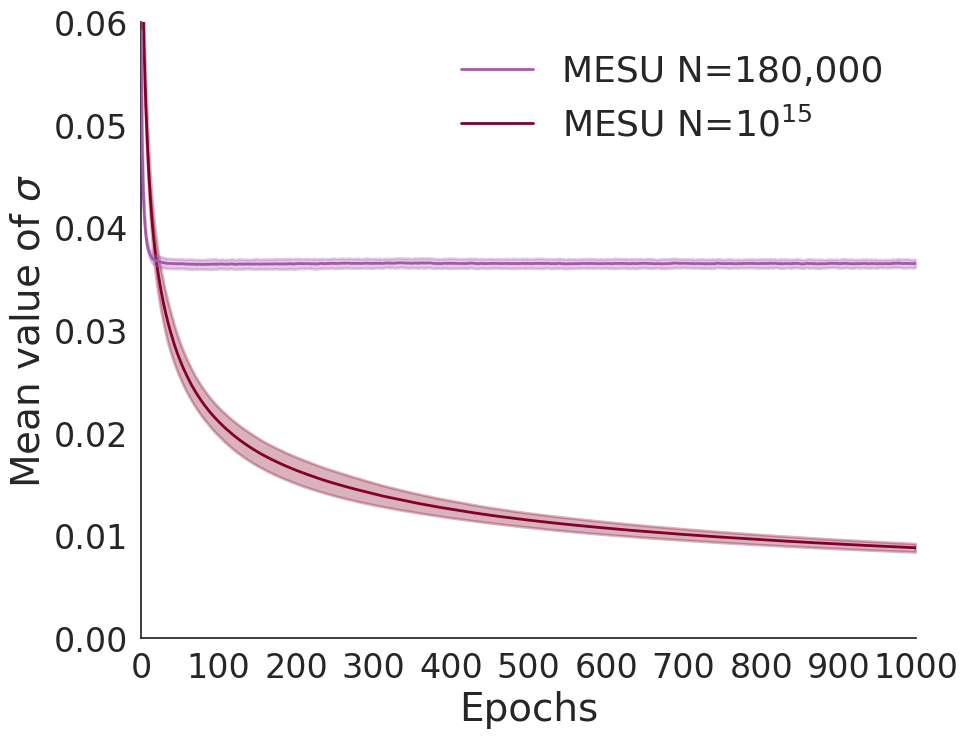

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)
for i, alg, name in zip(range(len(data)-2), data, names):
    if "FOO" in name or "MESU" in name:
        full_params_l0 = alg[-2]
        full_params_l1 = alg[-1]
        # Compute mean, std on synapses and samples
        full_params_l0_mean = full_params_l0.reshape(n_iterations, n_epochs, -1).mean(axis=(0, -1))
        full_params_l1_mean = full_params_l1.reshape(n_iterations, n_epochs, -1).mean(axis=(0, -1))
        full_params_l0_std = full_params_l0.reshape(n_iterations, n_epochs, -1).mean(axis=-1).std(axis=0)
        full_params_l1_std = full_params_l1.reshape(n_iterations, n_epochs, -1).mean(axis=-1).std(axis=0)
        # Compute the mean through layers
        full_params_mean = (full_params_l0_mean + full_params_l1_mean)/2
        full_params_std = (full_params_l0_std + full_params_l1_std)/2
        sns.lineplot(x=jnp.arange(n_epochs), y=full_params_mean, ax=ax, label=name, color=colors[i], linewidth= 3 if name == "MESU" else 2,
        zorder = 10 if name == "MESU N=180,000" else 1,)
        ax.fill_between(jnp.arange(n_epochs), full_params_mean - full_params_std, full_params_mean + full_params_std, color=colors[i], alpha=0.3, linewidth= 3 if name == "MESU" else 2,
        zorder = 10 if name == "MESU N=180,000" else 1,)           
ax.set_xlabel("Epochs", fontsize=AXESSIZE)
ax.set_ylabel("Mean value of $\sigma$", fontsize=AXESSIZE)
ax.set_xticks(jnp.arange(0, n_epochs+1, 100))
ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
ax.legend(loc="upper right", fontsize=LEGENDSIZE, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, n_epochs)
ax.set_ylim(0, 0.06)
plt.show()
# savefig as pdf
fig.savefig(os.path.join(FOLDER, "mnist-vanishing-sigma.svg"), bbox_inches="tight")
fig.savefig(os.path.join(FOLDER, "mnist-vanishing-sigma.pdf"), bbox_inches="tight")
plt.close()

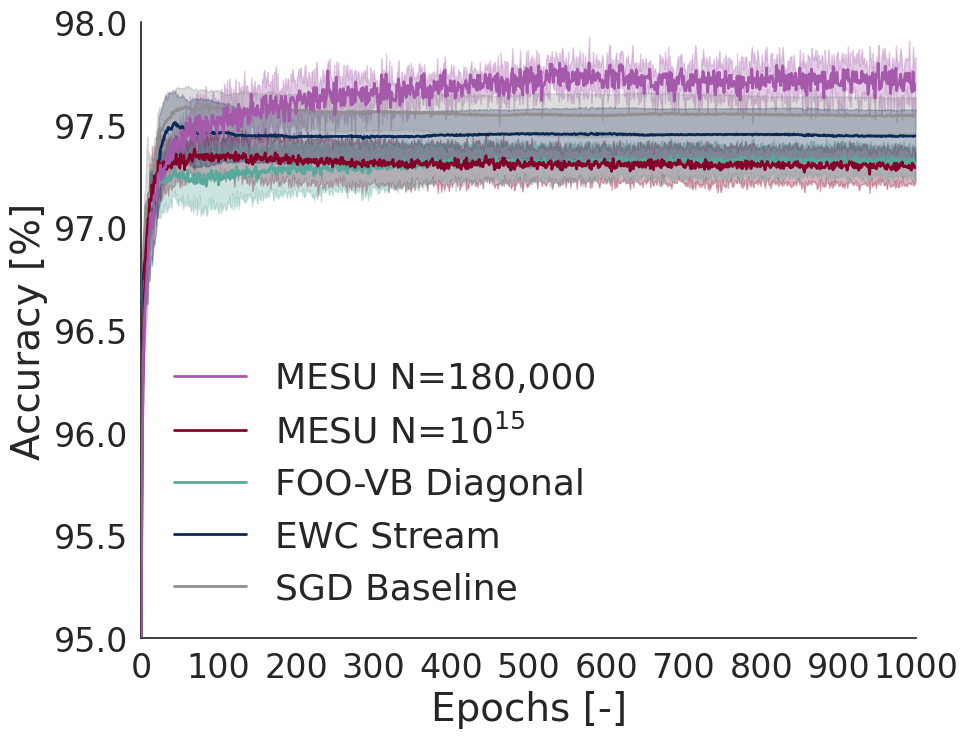

In [ ]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=FIGSIZE)
for i, alg, name in zip(range(len(data)), data, names):
    full_acc = alg[0]*100
    full_acc_mean = jnp.mean(full_acc, axis=0)[:, 0, 0]
    full_acc_std = jnp.std(full_acc, axis=0)[:, 0, 0]
    sns.lineplot(x=jnp.arange(n_epochs), y=full_acc_mean, ax=ax, label=name, color=colors[i], linewidth=2, zorder = 10 - i)
    ax.fill_between(jnp.arange(n_epochs), full_acc_mean - full_acc_std, full_acc_mean + full_acc_std, color=colors[i], alpha=0.3)
ax.set_xlabel("Epochs [-]", fontsize=AXESSIZE)
ax.set_ylabel("Accuracy [%]", fontsize=AXESSIZE)
ax.set_xticks(jnp.arange(0, n_epochs+1, 100))
ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
ax.legend(loc="lower left", fontsize=LEGENDSIZE, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, n_epochs)
ax.set_ylim(95, 98)
plt.show()
# savefig as pdf
fig.savefig(os.path.join(FOLDER, "mnist-acc.svg"), bbox_inches="tight")
fig.savefig(os.path.join(FOLDER, "mnist-acc.pdf"), bbox_inches="tight")
plt.close()

MESU N=180,000 ROC AUC: 0.9972368478775024


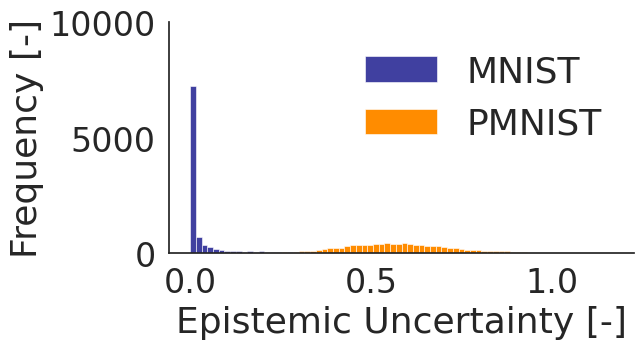

MESU N=$10^{15}$ ROC AUC: 0.7268244624137878


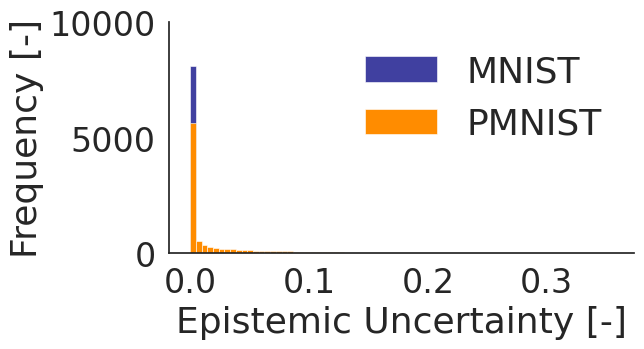

In [ ]:
bins = 75
for i, alg, name in zip(range(len(data)), data, names):
    if "BGD" in name or "MESU" in name:
        fig, ax = plt.subplots(figsize=(6, 3))
        full_mnist_epistemic = alg[3][0][-1]
        full_pmnist_epistemic = alg[4][0][-1]
        min_val = 0
        max_val = full_pmnist_epistemic.max()
        thresholds = jnp.linspace(min_val, max_val, 1000)
        tpr = jnp.array([jnp.mean(full_mnist_epistemic < t) for t in thresholds])
        fpr = jnp.array([jnp.mean(full_pmnist_epistemic < t) for t in thresholds])
        roc_auc = jnp.trapezoid(tpr, fpr)
        print(f"{name} ROC AUC: {roc_auc}")
        
        x_bins = jnp.linspace(min_val, max_val, bins)
        sns.histplot(full_mnist_epistemic, bins=x_bins, alpha=0.75, label="MNIST", ax=ax, color="navy")
        sns.histplot(full_pmnist_epistemic, bins=x_bins, alpha=1, label="PMNIST", ax=ax, color="darkorange")
        ax.set_xlabel("Epistemic Uncertainty [-]", fontsize=FONTSIZE)
        ax.set_ylabel("Frequency [-]", fontsize=FONTSIZE)
        ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
        ax.set_ylim(0, 10000)
        ax.legend(loc="upper right", fontsize=FONTSIZE, frameon=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()


MESU N=180,000 ROC AUC: 0.9969642162322998


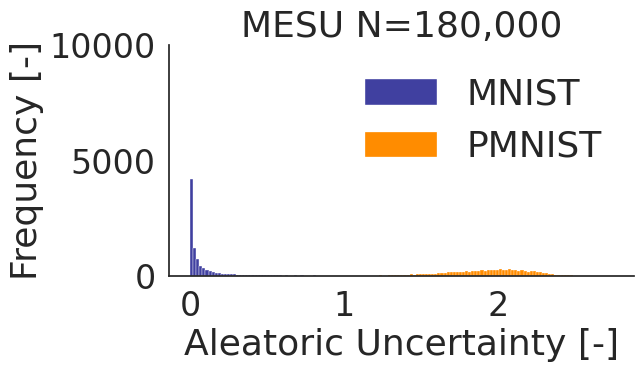

MESU N=$10^{15}$ ROC AUC: 0.7330551743507385


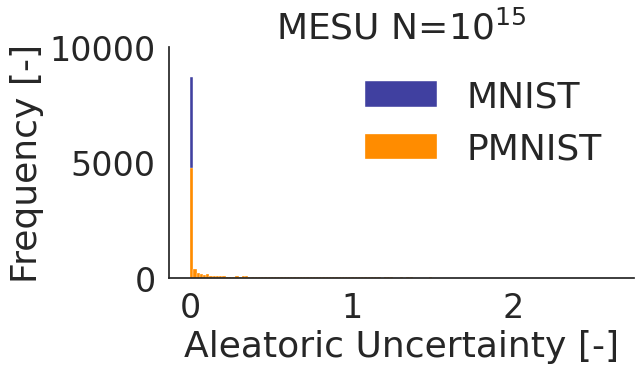

FOO-VB Diagonal ROC AUC: 0.7306348085403442


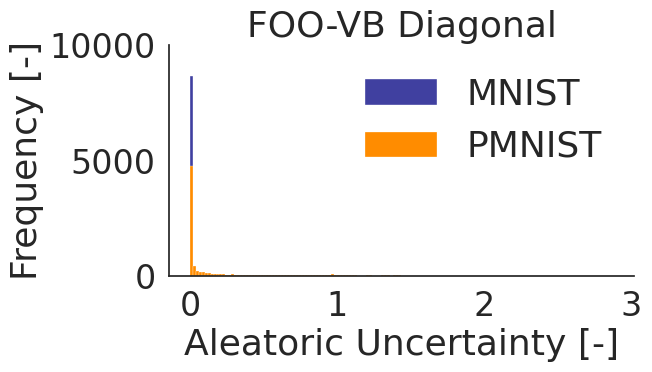

EWC Stream ROC AUC: 0.9115076065063477


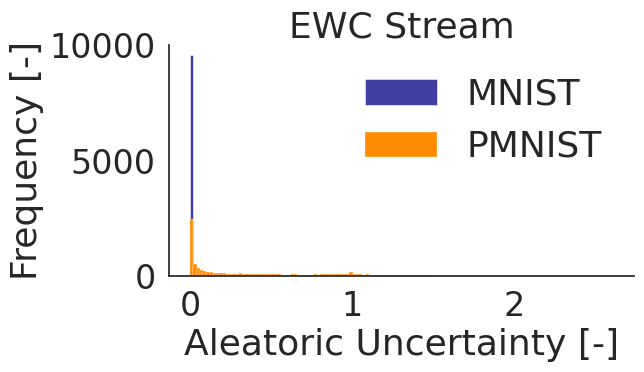

SGD Baseline ROC AUC: 0.9152026176452637


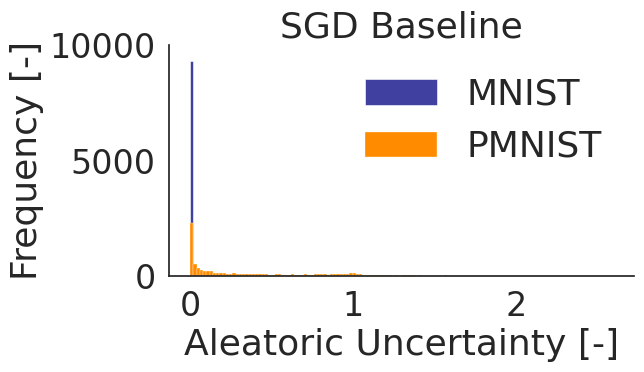

In [ ]:
bins = 100
for i, alg, name in zip(range(len(data)), data, names):
    fig, ax = plt.subplots(figsize=(6, 3))
    full_mnist_epistemic = alg[5][0][-1]
    full_pmnist_epistemic = alg[6][0][-1]
    # compute roc auc    
    min_val = 0
    max_val = full_pmnist_epistemic.max()
    thresholds = jnp.linspace(min_val, max_val, 1000)
    tpr = jnp.array([jnp.mean(full_mnist_epistemic < t) for t in thresholds])
    fpr = jnp.array([jnp.mean(full_pmnist_epistemic < t) for t in thresholds])
    roc_auc = jnp.trapezoid(tpr, fpr)
    print(f"{name} ROC AUC: {roc_auc}")
    
    x_bins = jnp.linspace(min_val, max_val, bins)
    sns.histplot(full_mnist_epistemic, bins=x_bins, alpha=0.75, label="MNIST", ax=ax, color="navy", binwidth=0.02)
    sns.histplot(full_pmnist_epistemic, bins=x_bins, alpha=1, label="PMNIST", ax=ax, color="darkorange", binwidth=0.02)
    ax.set_xlabel("Aleatoric Uncertainty [-]", fontsize=FONTSIZE)
    ax.set_ylabel("Frequency [-]", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICKSIZE)
    ax.set_ylim(0, 10000)
    ax.legend(loc="upper right", fontsize=FONTSIZE, frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(name, fontsize=FONTSIZE)
    plt.show()